
由於大多數的策略都是選擇腳3可以找到相同履約價的合約，代表又再次組成PCP，因此我們重點觀察此組成之新腳3與舊腳3之間的差異，主要從以下幾個角度切入：

1. 選擇權價格差異之分布圖 (也有分為SC、SP策略去做觀察)
2. 履約價

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from itertools import islice
from datetime import datetime, timedelta
import re
import os
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from matplotlib.gridspec import GridSpec
from matplotlib.ticker import MultipleLocator
from matplotlib.ticker import FuncFormatter
import matplotlib.gridspec as gridspec
from matplotlib.font_manager import FontProperties as font
import matplotlib
matplotlib.rc('font', family='Microsoft JhengHei') # 在圖表上顯示中文
import matplotlib.ticker as mtick
from collections import Counter
import seaborn as sns

In [46]:
df = pd.read_csv(r'D:\CODE\SC_SP_delay\持有跨夜\04_2025.csv',encoding = 'utf-8-sig')
df

,TradeTime,ArbitrageStrategy,StrikePrice,CallPrice_Diff,PutPrice_Diff,Price_Diff_Change,Price_Diff_Change_50X,Price_Diff_Origin,Price_Diff_Final,Price_Diff_Percentage,StrikePrice_Category,Extreme_Price_Diff,Performance_Ranking
0,2025-03-27 03:25:00,SC,22600,116.500000,0.000000,116.500000,5825.000000,-599.0,-482.500000,19.449082,High Strike,Normal,72.0
1,2025-03-28 03:08:00,SC,22600,67.966667,0.000000,67.966667,3398.333333,-749.3,-681.333333,9.070688,High Strike,Normal,99.0
2,2025-03-28 03:51:00,SC,22400,101.166667,0.000000,101.166667,5058.333333,-542.5,-441.333333,18.648233,High Strike,Normal,63.0
3,2025-03-28 03:52:00,SC,22350,93.000000,0.000000,93.000000,4650.000000,-503.0,-410.000000,18.489066,High Strike,Extreme,53.0
4,2025-03-28 03:52:00,SC,22350,93.000000,0.000000,93.000000,4650.000000,-503.0,-410.000000,18.489066,High Strike,Extreme,53.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
276,2025-04-16 03:01:00,SC,20200,-5.899065,0.000000,-5.899065,-294.953271,-382.0,-387.899065,-1.544258,Low Strike,Extreme,49.0
277,2025-04-16 05:00:00,SP,19700,0.000000,102.106295,102.106295,5105.314757,-114.0,-11.893705,89.566926,Low Strike,Extreme,29.0
278,2025-04-16 05:00:00,SP,19700,0.000000,102.106295,102.106295,5105.314757,-114.0,-11.893705,89.566926,Low Strike,Extreme,29.0
279,2025-04-16 05:00:00,SP,19800,0.000000,140.083051,140.083051,7004.152542,-13.0,127.083051,1077.561930,Low Strike,Extreme,26.0


### 整體績效 (只看腳3的價格波動)

In [47]:
# 計算累積PCP比數
cumulative_pcp = df["Price_Diff_Change"].count()

# 計算總損益
total_profit_loss = df["Price_Diff_Change_50X"].sum()

# 計算平均每筆PCP損益
average_profit_loss_per_pcp = total_profit_loss / len(df) if len(df) > 0 else 0

# 顯示結果
print("累積PCP比數:", cumulative_pcp)
print("總損益:", total_profit_loss)
print("平均每筆PCP損益:", average_profit_loss_per_pcp)

累積PCP比數: 281
總損益: 2394982.292683211
平均每筆PCP損益: 8523.068657235626


### 選擇權價格差異分布

count     281.000000
mean      170.461373
std       672.152555
min      -370.038462
25%       -90.186667
50%       -18.000000
75%        65.385714
max      2392.000000
Name: Price_Diff_Change, dtype: float64


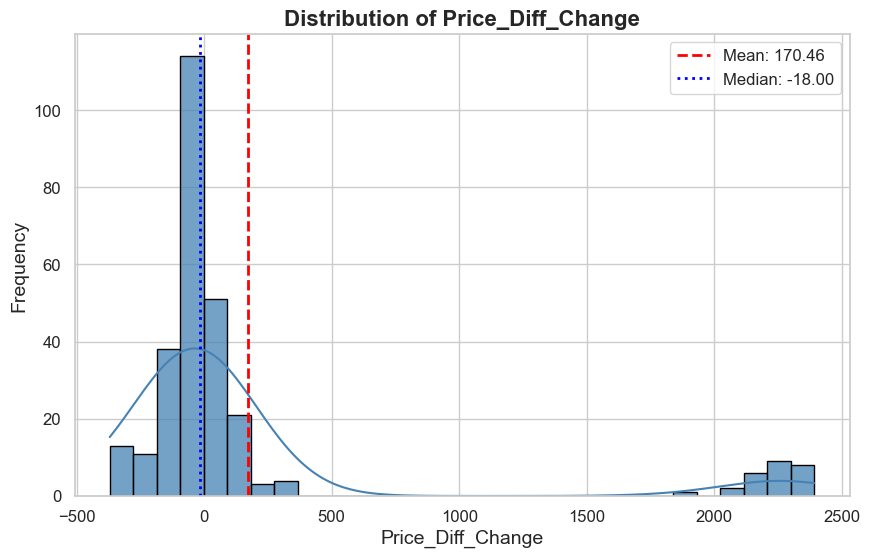

In [48]:
# 設置 Seaborn 風格
sns.set(style="whitegrid")

# **計算統計描述**
price_diff_stats = df["Price_Diff_Change"].describe()
print(price_diff_stats)

# **繪製美觀的分布圖**
plt.figure(figsize=(10, 6))
sns.histplot(df["Price_Diff_Change"], bins=30, kde=True, color="steelblue", edgecolor="black", alpha=0.75)

# **添加均值和中位數線**
mean_value = df["Price_Diff_Change"].mean()
median_value = df["Price_Diff_Change"].median()
plt.axvline(mean_value, color="red", linestyle="dashed", linewidth=2, label=f"Mean: {mean_value:.2f}")
plt.axvline(median_value, color="blue", linestyle="dotted", linewidth=2, label=f"Median: {median_value:.2f}")

# **美化標籤與標題**
plt.xlabel("Price_Diff_Change", fontsize=14)
plt.ylabel("Frequency", fontsize=14)
plt.title("Distribution of Price_Diff_Change", fontsize=16, fontweight="bold")
plt.legend(fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# **顯示圖表**
plt.show()


In [49]:
count_df = pd.DataFrame({
    "Condition": ["Price_Diff_Change >= 0", "Price_Diff_Change <= 0",
                  "Price_Diff_Change >= 40", "Price_Diff_Change <= -40",
                  "Price_Diff_Change >= 20", "Price_Diff_Change <= -20"],
    "Count": [len(df[df["Price_Diff_Change"] >= 0]),
              len(df[df["Price_Diff_Change"] <= 0]),
              len(df[df["Price_Diff_Change"] >= 40]),
              len(df[df["Price_Diff_Change"] <= -40]),
              len(df[df["Price_Diff_Change"] >= 20]),
              len(df[df["Price_Diff_Change"] <= -20])]
})

# 顯示結果
print(count_df)

                  Condition  Count
0    Price_Diff_Change >= 0     99
1    Price_Diff_Change <= 0    183
2   Price_Diff_Change >= 40     80
3  Price_Diff_Change <= -40    119
4   Price_Diff_Change >= 20     85
5  Price_Diff_Change <= -20    137


SC Strategy Stats:
count    234.000000
mean     -51.452489
std      110.771369
min     -370.038462
25%     -102.640000
50%      -36.253230
75%       -0.025000
max      303.500000
Name: Price_Diff_Change, dtype: float64

SP Strategy Stats:
count      47.000000
mean     1275.309114
std      1090.931869
min       -77.968254
25%        75.589511
50%      2110.000000
75%      2280.000000
max      2392.000000
Name: Price_Diff_Change, dtype: float64


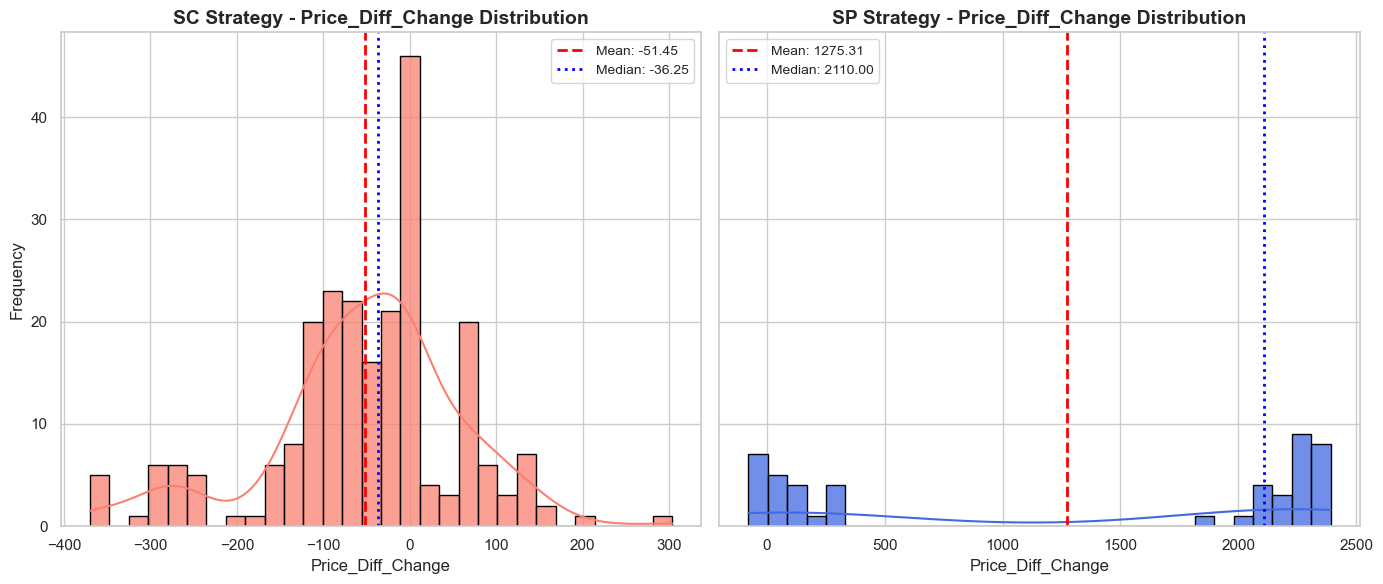

In [50]:
# 設置 Seaborn 風格
sns.set(style="whitegrid")

# **分割 SC / SP 數據**
df_sc = df[df["ArbitrageStrategy"] == "SC"]
df_sp = df[df["ArbitrageStrategy"] == "SP"]

# **計算統計描述**
print("SC Strategy Stats:")
print(df_sc["Price_Diff_Change"].describe())
print("\nSP Strategy Stats:")
print(df_sp["Price_Diff_Change"].describe())

# **繪製分布圖**
fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

# **SC 分布圖**
sns.histplot(df_sc["Price_Diff_Change"], bins=30, kde=True, color="salmon", edgecolor="black", alpha=0.75, ax=axes[0])
axes[0].axvline(df_sc["Price_Diff_Change"].mean(), color="red", linestyle="dashed", linewidth=2, label=f"Mean: {df_sc['Price_Diff_Change'].mean():.2f}")
axes[0].axvline(df_sc["Price_Diff_Change"].median(), color="blue", linestyle="dotted", linewidth=2, label=f"Median: {df_sc['Price_Diff_Change'].median():.2f}")
axes[0].set_title("SC Strategy - Price_Diff_Change Distribution", fontsize=14, fontweight="bold")
axes[0].set_xlabel("Price_Diff_Change", fontsize=12)
axes[0].set_ylabel("Frequency", fontsize=12)
axes[0].legend(fontsize=10)

# **SP 分布圖**
sns.histplot(df_sp["Price_Diff_Change"], bins=30, kde=True, color="royalblue", edgecolor="black", alpha=0.75, ax=axes[1])
axes[1].axvline(df_sp["Price_Diff_Change"].mean(), color="red", linestyle="dashed", linewidth=2, label=f"Mean: {df_sp['Price_Diff_Change'].mean():.2f}")
axes[1].axvline(df_sp["Price_Diff_Change"].median(), color="blue", linestyle="dotted", linewidth=2, label=f"Median: {df_sp['Price_Diff_Change'].median():.2f}")
axes[1].set_title("SP Strategy - Price_Diff_Change Distribution", fontsize=14, fontweight="bold")
axes[1].set_xlabel("Price_Diff_Change", fontsize=12)
axes[1].legend(fontsize=10)

# **調整間距**
plt.tight_layout()
plt.show()


In [51]:
# **計算 SC 和 SP 的個數**
sc_count = len(df[df["ArbitrageStrategy"] == "SC"])
sp_count = len(df[df["ArbitrageStrategy"] == "SP"])

# **計算 SC 和 SP 的累積損益**
sc_total_pnl = df[df["ArbitrageStrategy"] == "SC"]["Price_Diff_Change_50X"].sum()
sp_total_pnl = df[df["ArbitrageStrategy"] == "SP"]["Price_Diff_Change_50X"].sum()

# **計算 SC 和 SP 的平均 PnL**
sc_avg_pnl = sc_total_pnl / sc_count if sc_count > 0 else 0
sp_avg_pnl = sp_total_pnl / sp_count if sp_count > 0 else 0

# **整理成 DataFrame**
pnl_summary = pd.DataFrame({
    "Strategy": ["SC", "SP"],
    "Count": [sc_count, sp_count],
    "Total_PnL": [sc_total_pnl, sp_total_pnl],
    "Avg_PnL_per_Trade": [sc_avg_pnl, sp_avg_pnl]  # 每筆交易的平均 PnL
})

# **顯示結果**
print(pnl_summary)


  Strategy  Count     Total_PnL  Avg_PnL_per_Trade
0       SC    234 -6.019941e+05       -2572.624466
1       SP     47  2.996976e+06       63765.455698


### 履約價與價格差異關係

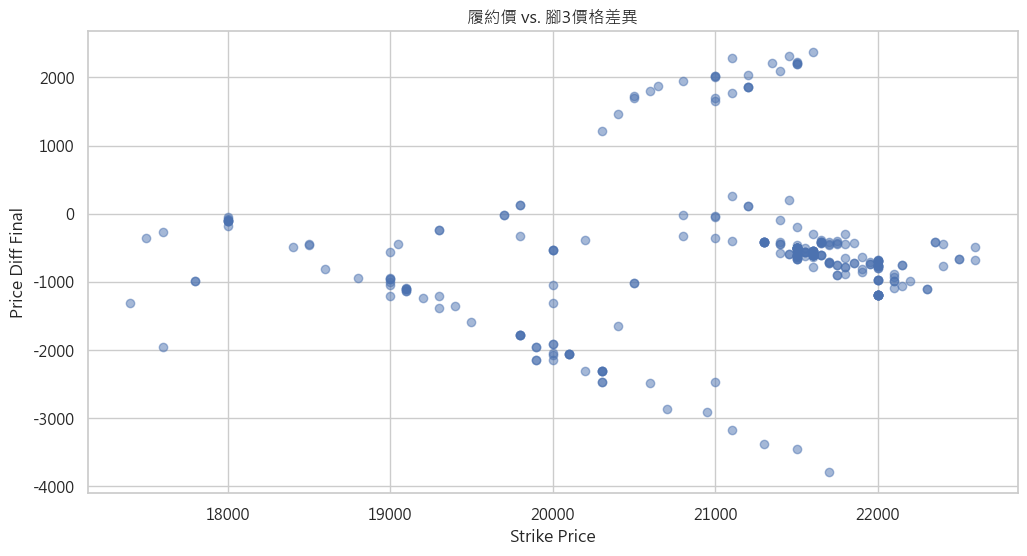

In [52]:
from matplotlib.font_manager import FontProperties as font
import matplotlib
matplotlib.rc('font', family='Microsoft JhengHei') # 在圖表上顯示中文

# 繪製履約價 vs. 最終價格差異的散點圖
fig, ax = plt.subplots(figsize=(12, 6))
plt.scatter(df["StrikePrice"], df["Price_Diff_Final"], alpha=0.5)
plt.xlabel("Strike Price")
plt.ylabel("Price Diff Final")
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f"{x:.0f}"))  # 確保負號能正常顯示
plt.title("履約價 vs. 腳3價格差異")
plt.show()


大多數數據點集中在履約價23500~24500及價格差異-500~500之間 (-10~10點之間)

集中區域：

大部分數據集中在 價格差異較小 (-500 ~ 500) 的區間，這可能代表此區間內的套利空間較小，市場定價較為合理。

履約價 23500~24500 內的數據點最密集，可能是市場交易活躍的履約價範圍。

價格差異極端值：

少數點落在 ±2000 的區間，代表極端情境可能出現較大的套利機會或市場定價錯誤。

進一步分析 哪些履約價產生極端價格差異，是否與流動性、波動性、開盤前後變化有關。

C:\Users\ptdintern1.fut\AppData\Local\Temp\ipykernel_19888\1952900823.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby("StrikePrice_Group")["Price_Diff_Final"].mean().plot(kind="bar", figsize=(10,6), title="履約價區間 vs. 平均價格差異")


<Axes: title={'center': '履約價區間 vs. 平均價格差異'}, xlabel='StrikePrice_Group'>

c:\Users\ptdintern1.fut\AppData\Local\anaconda3\Lib\site-packages\IPython\core\events.py:82: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) Microsoft JhengHei.
  func(*args, **kwargs)
c:\Users\ptdintern1.fut\AppData\Local\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) Microsoft JhengHei.
  fig.canvas.print_figure(bytes_io, **kw)


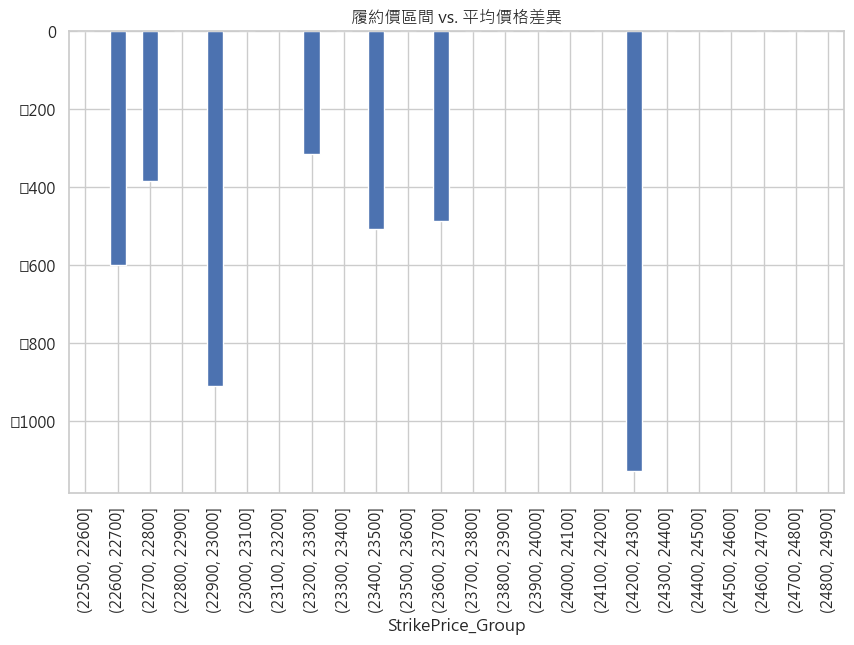

In [96]:
df["StrikePrice_Group"] = pd.cut(df["StrikePrice"], bins=range(22500, 25000, 100))
df.groupby("StrikePrice_Group")["Price_Diff_Final"].mean().plot(kind="bar", figsize=(10,6), title="履約價區間 vs. 平均價格差異")

觀察極端值

In [41]:
extreme_pcp = df[df["Price_Diff_Final"].abs() > 1000]
extreme_pcp.groupby("StrikePrice")["Price_Diff_Final"].describe()


,count,mean,std,min,25%,50%,75%,max
StrikePrice,,,,,,,,
22200,4.0,-1879.800000,0.000000,-1879.800000,-1879.800000,-1879.800000,-1879.800000,-1879.80000
22300,3.0,-1417.666667,456.684063,-1945.000000,-1549.500000,-1154.000000,-1154.000000,-1154.00000
22400,1.0,-1211.500000,NaN,-1211.500000,-1211.500000,-1211.500000,-1211.500000,-1211.50000
22800,2.0,-1370.276471,128.094473,-1460.852941,-1415.564706,-1370.276471,-1324.988235,-1279.70000
22900,1.0,-1318.845070,NaN,-1318.845070,-1318.845070,-1318.845070,-1318.845070,-1318.84507


<Axes: xlabel='StrikePrice', ylabel='Price_Diff_Final'>

c:\Users\ptdintern1.fut\AppData\Local\anaconda3\Lib\site-packages\IPython\core\events.py:82: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) Microsoft JhengHei.
  func(*args, **kwargs)
c:\Users\ptdintern1.fut\AppData\Local\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) Microsoft JhengHei.
  fig.canvas.print_figure(bytes_io, **kw)


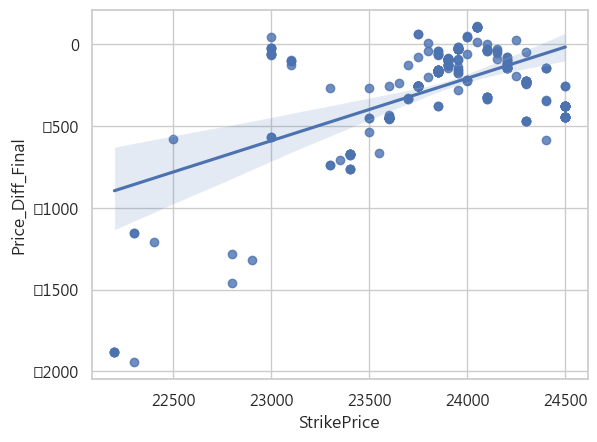

In [42]:
sns.regplot(x=df["StrikePrice"], y=df["Price_Diff_Final"])

### 高價 vs. 低價合約的套利表現

c:\Users\ptdintern1.fut\AppData\Local\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) Microsoft JhengHei.
  fig.canvas.print_figure(bytes_io, **kw)


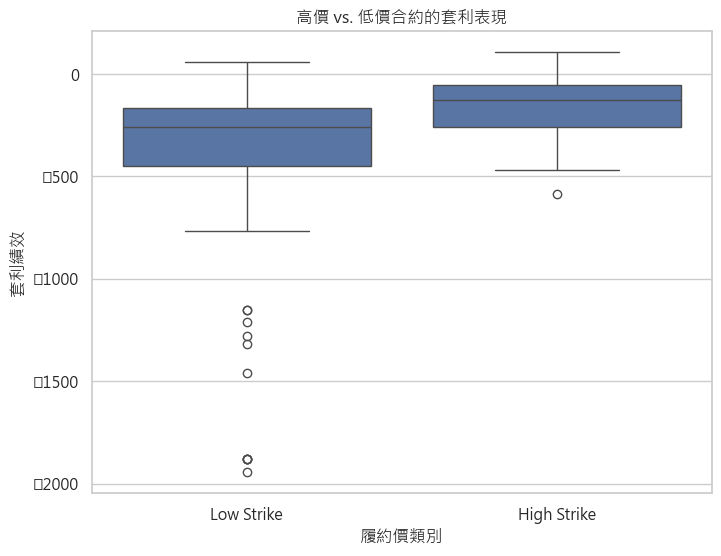

In [36]:
# 使用箱型圖來查看不同履約價區間的套利效果
plt.figure(figsize=(8, 6))
sns.boxplot(x=df["StrikePrice_Category"], y=df["Price_Diff_Final"])
plt.xlabel("履約價類別")
plt.ylabel("套利績效")
plt.title("高價 vs. 低價合約的套利表現")
plt.show()

### 極端情況分析

In [37]:
# 計算不同極端情況的平均套利差異
df.groupby("Extreme_Price_Diff")["Price_Diff_Final"].describe()

,count,mean,std,min,25%,50%,75%,max
Extreme_Price_Diff,,,,,,,,
Extreme,142.0,-344.064002,444.960165,-1945.000000,-465.764315,-92.002095,-32.632391,106.938053
Normal,186.0,-211.602850,82.276273,-376.965007,-256.988202,-219.780236,-148.916309,-93.002095


### 策略優化：不同選擇方式的績效比較

In [38]:
df.groupby(["ArbitrageStrategy", "StrikePrice_Category"])["Performance_Ranking"].mean()

ArbitrageStrategy  StrikePrice_Category
SC                 High Strike             77.828571
                   Low Strike              48.120000
SP                 High Strike             30.807018
                   Low Strike              93.432624
Name: Performance_Ranking, dtype: float64

In [82]:
df_1 = pd.read_csv('D:\CODE\PCP2014_20250319.csv',encoding = 'utf-8-sig')

<>:1: SyntaxWarning: invalid escape sequence '\C'
<>:1: SyntaxWarning: invalid escape sequence '\C'
C:\Users\ptdintern1.fut\AppData\Local\Temp\ipykernel_19888\2052077245.py:1: SyntaxWarning: invalid escape sequence '\C'
  df_1 = pd.read_csv('D:\CODE\PCP2014_20250319.csv',encoding = 'utf-8-sig')


In [83]:
df_1

,Unnamed: 0,IAccountID,BS,CommodityId,TradeDate,TradeTime,Qty,Price
0,1,PCP,S,TXO17100A4,2024/1/2,2024/1/2 09:05,4,840.0
1,2,PCP,B,MXFA4,2024/1/2,2024/1/2 09:05,4,17913.0
2,3,PCP,B,TXO17100M4,2024/1/2,2024/1/2 09:05,4,22.0
3,4,PCP,B,MXFA4,2024/1/2,2024/1/2 09:05,4,17913.0
4,5,PCP,B,TXO17100M4,2024/1/2,2024/1/2 09:05,4,22.0
...,...,...,...,...,...,...,...,...
28496,28497,PCP,B,MXFC5,2025/3/19,2025/3/19 13:29,1,21964.0
28497,28498,PCP,S,MXFC5,2025/3/19,2025/3/19 13:29,1,21963.0
28498,28499,PCP,B,TXO22700C5,2025/3/19,2025/3/19 13:29,1,0.2
28499,28500,PCP,S,TXO22700O5,2025/3/19,2025/3/19 13:29,1,745.0


In [85]:
import pandas as pd

# 確保 TradeTime 是字串格式
df_1['TradeTime'] = df_1['TradeTime'].astype(str)

# 轉換成 datetime，讓 pandas 自動識別格式
df_1['TradeTime'] = pd.to_datetime(df_1['TradeTime'], errors='coerce')

# 提取時分
df_1['HourMinute'] = df_1['TradeTime'].dt.strftime('%H:%M')

# 篩選時間界在 03:00 ~ 05:00
df_filtered = df_1[(df_1['TradeTime'].dt.hour >= 3) & (df_1['TradeTime'].dt.hour <= 5)]

print(df_filtered)


       Unnamed: 0 IAccountID BS CommodityId  TradeDate           TradeTime  \
7461         7462        PCP  B       MXFD4  2024/4/11 2024-04-12 03:45:00   
7462         7463        PCP  B       MXFD4  2024/4/11 2024-04-12 04:16:00   
7578         7579        PCP  S       MXFD4  2024/4/12 2024-04-13 03:50:00   
7579         7580        PCP  S       MXFD4  2024/4/12 2024-04-13 03:50:00   
7580         7581        PCP  S       MXFD4  2024/4/12 2024-04-13 04:09:00   
...           ...        ... ..         ...        ...                 ...   
13124       13125        PCP  B       MXFF4  2024/5/27 2024-05-28 03:30:00   
13125       13126        PCP  B       MXFF4  2024/5/27 2024-05-28 03:30:00   
13126       13127        PCP  B       MXFF4  2024/5/27 2024-05-28 03:30:00   
13127       13128        PCP  B       MXFF4  2024/5/27 2024-05-28 03:30:00   
13211       13212        PCP  B       MXFF4  2024/5/28 2024-05-29 04:58:00   

       Qty    Price HourMinute  
7461     1  20770.0      03:45

In [88]:
df_filtered.to_csv('D:\CODE\PCP_total_data.csv',encoding = 'utf-8-sig')

<>:1: SyntaxWarning: invalid escape sequence '\C'
<>:1: SyntaxWarning: invalid escape sequence '\C'
C:\Users\ptdintern1.fut\AppData\Local\Temp\ipykernel_19888\1032808214.py:1: SyntaxWarning: invalid escape sequence '\C'
  df_filtered.to_csv('D:\CODE\PCP_total_data.csv',encoding = 'utf-8-sig')


In [77]:
df_1

,Unnamed: 0,IAccountID,BS,CommodityId,Qty,Price,YearMonthDay,HourMinute
0,1,PCP,S,TXO17100A4,4,840.0,2024/1/2,2024/
1,2,PCP,B,MXFA4,4,17913.0,2024/1/2,2024/
2,3,PCP,B,TXO17100M4,4,22.0,2024/1/2,2024/
3,4,PCP,B,MXFA4,4,17913.0,2024/1/2,2024/
4,5,PCP,B,TXO17100M4,4,22.0,2024/1/2,2024/
...,...,...,...,...,...,...,...,...
28496,28497,PCP,B,MXFC5,1,21964.0,2025/3/19,2025/
28497,28498,PCP,S,MXFC5,1,21963.0,2025/3/19,2025/
28498,28499,PCP,B,TXO22700C5,1,0.2,2025/3/19,2025/
28499,28500,PCP,S,TXO22700O5,1,745.0,2025/3/19,2025/
